# CSE527 Homework 4
**Due date: 23:59 on Nov. 5, 2019 (Thuesday)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

Remember Homework 3: Scene recognition with bag of words. You worked hard to design a bag of features representations that achieved 60% to 70% accuracy (most likely) on 16-way scene classification. We're going to attack the same task with deep learning and get higher accuracy. Training from scratch won't work quite as well as homework 3 due to the insufficient amount of data, fine-tuning an existing network will work much better than homework 3.

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 2,400 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

There are 2 problems in this homework with a total of 110 points including 10 bonus points. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/open?id=1NWC3TMsXSWN2TeoYMCjhf2N1b-WRDh-M) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.


## Starter Code
---
In the starter code, you are provided with a function that loads data into minibatches for training and testing in PyTorch.

In [0]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import gc

In [3]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
# Set your working directory (in your google drive)
# Note that 'gdrive/My Drive/Y2019Fall/CSE-527-Intro-To-Computer-Vision/hw4' is just an example, 
#   change it to your specific homework directory.
cd '/content/gdrive/My Drive/Chintapalli_Saketh_112686022_hw4'

/content/gdrive/My Drive/Chintapalli_Saketh_112686022_hw4


In [7]:
# ==========================================
#    Load Training Data and Testing Data
# ==========================================
class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)
n_train_samples = 150
n_test_samples = 50


def img_norm(img):
  #
  # Write your code here
  # normalize img pixels to [-1, 1]
  #
  img = (img - img.min())/(img.max()-img.min())
  return img
def load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False,
                rotate_90=False, zero_centered=False):
    
    data = []
    labels = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            #img = np.float32(img)
            data.append(img_norm(img))
            
    #
    # Write your Data Augmentation code here
    # mirroring
    #
    if augment:
        iter = 1
        for i in range(2400):
            #flip_img = cv2.flip(img,1) #Mirroring around vertical axis
            data.append(cv2.flip(data[i],1))
            labels.append(labels[i])
            gc.collect()
        print(len(data))
        print(len(labels))
    
         
    #
    # Write your Data Normalization code here
    # norm data to zero-centered
    #
    if zero_centered:
        for img in data:
            img = (img-np.mean(img))/np.std(img)
     
    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        print(len(data))
        print(batch_num)
        
        for i in range(int(len(data) / batch_num)):
            minibatch_d = data[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

class_names: {0: 'Forest', 1: 'Industrial', 2: 'Flower', 3: 'Coast', 4: 'InsideCity', 5: 'Office', 6: 'Bedroom', 7: 'Highway', 8: 'Street', 9: 'TallBuilding', 10: 'LivingRoom', 11: 'Suburb', 12: 'OpenCountry', 13: 'Mountain', 14: 'Kitchen', 15: 'Store'} 


In [8]:
# load data into size (64, 64)
img_size = (64, 64)
batch_num = 50 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True, zero_centered=True, is_color = False))
train_num = len(trainloader_small)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num, is_color=False))
test_num = len(testloader_small)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
4800
4800
4800
50
Finish loading 96 minibatches(=50) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images f

TallBuilding


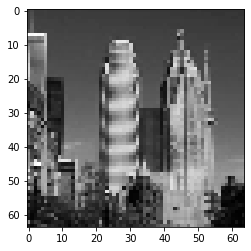

In [9]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Problem 1: Training a Network From Scratch
{Part 1: 35 points} Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective (in this case, 16-way classification accuracy). Instead of 70% accuracy we can now recognize scenes with... 25% accuracy. OK, that didn't work at all. Try to boost the accuracy by doing the following:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you left-right flip (mirror) an image of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 2,400 original training images as much (because it sees 4,800 training images now, although they're not as good as 4,800 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You should see a roughly 10% increase in accuracy by adding mirroring. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. After doing this you should see another 15% or so increase in accuracy. This part is **required**.

**Network Regularization**: Add dropout layer. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer. Your test accuracy should increase by another 10%. Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. 

If you increase the number of training epochs (and maybe decrease the learning rate) you should be able to achieve around 50% test accuracy. In this part, you are **required** to add dropout layer to your network.

Please give detailed descriptions of your network layout in the following format:<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
Then report the final accuracy on test set and time consumed for training and testing separately.

{Part 2: 15 points} Try **three techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

In [0]:
# ==========================================
#       Define Network Architecture
# ==========================================
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv_drop = nn.Dropout(0.5) 
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(14*14*128, 512)  
        self.fc2 = nn.Linear(512, 84)
        self.fc3 = nn.Linear(84, 16)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.relu(F.max_pool2d(self.conv_drop(self.conv2(x)), 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features 


My network consists of two convolutional layers, three linear layers, and one dropout layer before the second convolutional layer.

1. Data Augmentation: I used cv2.flip to flip the images along the vertical axis(mirroring), thereby doubling the size of my training set. 2400 images became 4800 images, as each image was mirrored.
2. Data Normalization: I subtracted the mean from every image and divided the images by the standard deviation of the pixel values.
3. Layer 1: Convolutional layer, 3x3 mask.
4. Layer 2: Convolutional layer, 3x3 mask.
5. Layer 3: Linear Layer, 14x14x128 input nodes, 512 output nodes
6. Layer 4: Linear Layer, 512 input nodes, 84 output nodes
7. Layer 5: Linear Layer, 84 input nodes, 16 output nodes(classification)

In [20]:
# ==========================================
#         Optimize/Train Network
# ==========================================
import time
start_time = time.time()
epochs = 20
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for epoch in range(epochs):
    epoch_loss = 0.0
    for batches in range(train_num):
        #"use trainloader to get the input images" 
        x = trainloader_small[batches][0]
        x = x.to(device)
        t =  trainloader_small[batches][1]
        t = t.to(device)
        optimizer.zero_grad()
        y = model(x.float())
        loss = criterion(y,t)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print('Avg_loss:',epoch_loss)
elapsed = time.time() - start_time
print('Elapsed Training Time: ' + str(elapsed) + " seconds")

Avg_loss: 257.5131764411926
Avg_loss: 224.75595927238464
Avg_loss: 199.9579598903656
Avg_loss: 184.86652255058289
Avg_loss: 174.20055401325226
Avg_loss: 165.45192205905914
Avg_loss: 156.88650023937225
Avg_loss: 148.48868310451508
Avg_loss: 139.46769201755524
Avg_loss: 131.57501566410065
Avg_loss: 124.28830140829086
Avg_loss: 117.80961710214615
Avg_loss: 111.82655990123749
Avg_loss: 106.27720242738724
Avg_loss: 100.95340210199356
Avg_loss: 96.03636407852173
Avg_loss: 91.39292347431183
Avg_loss: 86.7926254272461
Avg_loss: 82.40384662151337
Avg_loss: 78.40321856737137
Elapsed Training Time: 28.39750647544861 seconds


In [23]:
# ==========================================
#            Evaluating Network
# ==========================================
start_time = time.time()
PATH = './trained.pth'
torch.save(model.state_dict(), PATH)
net = Net()
net.load_state_dict(torch.load(PATH))
net = net.to(device)
total = 0
correct = 0
for batches in range(test_num):
    #"use trainloader to get the input images" 
    x = testloader_small[batches][0]
    x = x.to(device)
    t =  testloader_small[batches][1]
    t = t.to(device)
    y = net(x.float())
    _, predicted = torch.max(y.data, 1)
    total = total + x.size()[0]
    correct += (predicted == t).sum().item()
print('Accuracy of the network on the 400 test images: %d %%' % (
    100 * correct / total))
elapsed = time.time() - start_time
print('Testing Time Elapsed: ' + str(elapsed) + " seconds")

Accuracy of the network on the 400 test images: 51 %
Testing Time Elapsed: 0.42687392234802246 seconds


**Technique 1**
To try and improve my model, I tried to add batch normalization to my neural network. I added batch normalization on the second-last linear layer, but to my surprise, this decreased my accuracy by 20%. 

In [0]:
#Technique 1
# ==========================================
#       Define Network Architecture
# ==========================================
class Net1(nn.Module):

    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv_drop = nn.Dropout(0.5) 
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(14*14*128, 512)  
        self.fc2 = nn.Linear(512, 84)
        self.b_norm = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 16)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.relu(F.max_pool2d(self.conv_drop(self.conv2(x)), 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.b_norm(self.fc2(x)))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features 
  

In [11]:
#Technique 1
# ==========================================
#         Optimize/Train Network
# ==========================================
epochs = 20
model = Net1()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

for epoch in range(epochs):
    epoch_loss = 0.0
    for batches in range(train_num):
        #"use trainloader to get the input images" 
        x = trainloader_small[batches][0]
        t =  trainloader_small[batches][1]
        optimizer.zero_grad()
        y = model(x.float())
        loss = criterion(y,t)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print('Avg_loss:',epoch_loss)


Avg_loss: 223.17668557167053
Avg_loss: 176.43907558918
Avg_loss: 144.02682721614838
Avg_loss: 119.31225180625916
Avg_loss: 98.25309824943542
Avg_loss: 80.62187159061432
Avg_loss: 64.96653711795807
Avg_loss: 52.09840548038483
Avg_loss: 41.43240296840668
Avg_loss: 33.12205296754837
Avg_loss: 26.639933839440346
Avg_loss: 21.383524119853973
Avg_loss: 17.3174317330122
Avg_loss: 14.360657766461372
Avg_loss: 11.48439171910286
Avg_loss: 9.174353562295437
Avg_loss: 7.303208235651255
Avg_loss: 5.961582660675049
Avg_loss: 5.088070970028639
Avg_loss: 4.369649235159159


In [12]:
#Technique 1
# ==========================================
#            Evaluating Network
# ==========================================
PATH = './trained.pth'
torch.save(model.state_dict(), PATH)
net = Net1()
net.load_state_dict(torch.load(PATH))
total = 0
correct = 0
for batches in range(test_num):
    #"use trainloader to get the input images" 
    x = testloader_small[batches][0]
    t =  testloader_small[batches][1]
    y = net(x.float())
    _, predicted = torch.max(y.data, 1)
    total = total + x.size()[0]
    correct += (predicted == t).sum().item()
print('Accuracy of the network on the 400 test images using batch normalization: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 400 test images using batch normalization: 31 %


**Technique 2- Different Activation Function**
For this technique, I decided to use leaky_relu activation function instead of just relu. This improved my test-set accuracy from 51% to 54%. Also, training time was not significantly different from the original architecture.

In [0]:
#Technique 2
# ==========================================
#       Define Network Architecture
# ==========================================
class Net2(nn.Module):

    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv_drop = nn.Dropout(0.5) 
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(14*14*128, 512)  
        self.fc2 = nn.Linear(512, 84)
        self.fc3 = nn.Linear(84, 16)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.relu(F.max_pool2d(self.conv_drop(self.conv2(x)), 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features 
  

In [118]:
#Technique 2
# ==========================================
#         Optimize/Train Network
# ==========================================
epochs = 20
model = Net2()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

for epoch in range(epochs):
    epoch_loss = 0.0
    for batches in range(train_num):
        #"use trainloader to get the input images" 
        x = trainloader_small[batches][0]
        t =  trainloader_small[batches][1]
        optimizer.zero_grad()
        y = model(x.float())
        loss = criterion(y,t)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print('Avg_loss:',epoch_loss)


Avg_loss: 257.25745677948
Avg_loss: 216.93312287330627
Avg_loss: 190.36986637115479
Avg_loss: 173.69928240776062
Avg_loss: 159.07277989387512
Avg_loss: 145.5146288871765
Avg_loss: 132.323282122612
Avg_loss: 119.45193034410477
Avg_loss: 108.10053300857544
Avg_loss: 98.9412409067154
Avg_loss: 90.17985665798187
Avg_loss: 82.3539651632309
Avg_loss: 75.41423773765564
Avg_loss: 68.39724153280258
Avg_loss: 61.69322890043259
Avg_loss: 55.98877930641174
Avg_loss: 50.6947104036808
Avg_loss: 46.23956570029259
Avg_loss: 41.59548059105873
Avg_loss: 38.019248098134995


In [119]:
#Technique 2
# ==========================================
#            Evaluating Network
# ==========================================
PATH = './trained.pth'
torch.save(model.state_dict(), PATH)
net = Net2()
net.load_state_dict(torch.load(PATH))
total = 0
correct = 0
for batches in range(test_num):
    #"use trainloader to get the input images" 
    x = testloader_small[batches][0]
    t =  testloader_small[batches][1]
    y = net(x.float())
    _, predicted = torch.max(y.data, 1)
    total = total + x.size()[0]
    correct += (predicted == t).sum().item()
print('Accuracy of the network on the 400 test images using leaky relu activation: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 400 test images using leaky relu activation: 54 %


**Technique 3 - Change Size of Mask, Extra Layer**

For this technique, I decided to change the size of the convolutional layer mask to be 5x5 instead of 3x3. Also, I added a new linear layer to the ending of my network architecture. This is defined as self.fc4 for your reference. I found that these two changes, although added some extra time for training, increased the accuracy of my test dataset from 51% to 54%.

In [0]:
#Technique 3
# ==========================================
#       Define Network Architecture
# ==========================================
class Net2(nn.Module):

    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 5)
        self.conv_drop = nn.Dropout(0.5) 
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.fc1 = nn.Linear(13*13*128, 256)  
        self.fc2 = nn.Linear(256, 120)
        self.fc3 = nn.Linear(120,64)
        self.fc4 = nn.Linear(64, 16)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.relu(F.max_pool2d(self.conv_drop(self.conv2(x)), 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features 
  

In [127]:
#Technique 2
# ==========================================
#         Optimize/Train Network
# ==========================================
epochs = 20
model = Net2()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

for epoch in range(epochs):
    epoch_loss = 0.0
    for batches in range(train_num):
        #"use trainloader to get the input images" 
        x = trainloader_small[batches][0]
        t =  trainloader_small[batches][1]
        optimizer.zero_grad()
        y = model(x.float())
        loss = criterion(y,t)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print('Avg_loss:',epoch_loss)


Avg_loss: 258.448007106781
Avg_loss: 220.81606674194336
Avg_loss: 197.9824721813202
Avg_loss: 182.44998788833618
Avg_loss: 169.655304312706
Avg_loss: 157.58930253982544
Avg_loss: 146.46336221694946
Avg_loss: 135.8632435798645
Avg_loss: 127.51021885871887
Avg_loss: 120.42594164609909
Avg_loss: 113.91100513935089
Avg_loss: 107.92660748958588
Avg_loss: 102.44119518995285
Avg_loss: 97.83137118816376
Avg_loss: 92.66919726133347
Avg_loss: 88.46829128265381
Avg_loss: 83.77636080980301
Avg_loss: 78.77526849508286
Avg_loss: 74.4653137922287
Avg_loss: 69.78860774636269


In [128]:
#Technique 3
# ==========================================
#            Evaluating Network
# ==========================================
PATH = './trained.pth'
torch.save(model.state_dict(), PATH)
net = Net2()
net.load_state_dict(torch.load(PATH))
total = 0
correct = 0
for batches in range(test_num):
    #"use trainloader to get the input images" 
    x = testloader_small[batches][0]
    t =  testloader_small[batches][1]
    y = net(x.float())
    _, predicted = torch.max(y.data, 1)
    total = total + x.size()[0]
    correct += (predicted == t).sum().item()
print('Accuracy of the network on the 400 test images using extra linear layer and 5x5 mask: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 400 test images using extra linear layer and 5x5 mask: 54 %


## Problem 2: Fine Tuning a Pre-Trained Deep Network
{Part 1: 30 points} Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.

**Strategy A**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 200 activations. 

**Strategy B**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 16 classes) this is an attractive option. Fine-tuning can work far better than Strategy A of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

You are required to implement **Strategy B** to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve performance of 85% approximately. It takes roughly 35~40 minutes to train 20 epoches with AlexNet.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set along with time consumption for both training and testing <br>

{Part 2: 20 points} Implement Strategy A where you use the activations of the pre-trained network as features to train one-vs-all SVMs for your scene classification task. Report the final accuracy on test set along with time consumption for both training and testing.

{Bonus: 10 points} Bonus will be given to those who fine-tune the [VGG network](https://pytorch.org/docs/stable/_modules/torchvision/models/vgg.html) [paper](https://arxiv.org/pdf/1409.1556.pdf) and compare performance with AlexNet. Explain why VGG performed better or worse.

**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [25]:
# reload data with a larger size
img_size = (224, 224)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=False, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_large = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num, is_color=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
2400
50
Finish loading 48 minibatches(=50) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class:

In [26]:
# ==========================================
#       Fine-Tune Pretrained Network
# ==========================================
from torchvision import datasets, models, transforms
start_time = time.time()
pre_model = models.alexnet(pretrained = True)
features = pre_model.classifier[6].in_features
pre_model.classifier[6] = nn.Linear(features, 16)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pre_model = pre_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(pre_model.parameters(), lr=0.001, momentum=0.9)
epochs = 20

for epoch in range(epochs):
    epoch_loss = 0.0
    for batches in range(train_num):
        #"use trainloader to get the input images" 
        x = trainloader_large[batches][0]
        x = x.to(device)
        t =  trainloader_large[batches][1]
        t = t.to(device)
        pre_model.train()
        optimizer.zero_grad()
        inputs = x.float()
        y = pre_model(inputs)
        loss = criterion(y,t)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print('Avg_loss:',epoch_loss)
elapsed = time.time() - start_time
print('Training time: ' + str(elapsed) + " seconds")

Avg_loss: 60.8310521543026
Avg_loss: 25.25791585445404
Avg_loss: 19.519167989492416
Avg_loss: 16.234412789344788
Avg_loss: 13.795408964157104
Avg_loss: 10.64403946697712
Avg_loss: 10.27199161797762
Avg_loss: 8.613945819437504
Avg_loss: 8.502506203949451
Avg_loss: 7.519562114030123
Avg_loss: 7.43598123639822
Avg_loss: 6.461423318833113
Avg_loss: 5.908243138343096
Avg_loss: 4.651742693036795
Avg_loss: 3.997445269487798
Avg_loss: 3.9531413596123457
Avg_loss: 3.268549661152065
Avg_loss: 2.614854710176587
Avg_loss: 2.7844313299283385
Avg_loss: 2.9649138459935784
Training time: 36.92308211326599 seconds


In [27]:
PATH = './trained.pth'
start_time = time.time()
torch.save(pre_model.state_dict(), PATH)
net = pre_model
net.load_state_dict(torch.load(PATH))
total = 0
correct = 0
for batches in range(test_num):
    #"use trainloader to get the input images" 
    x = testloader_large[batches][0]
    x = x.to(device)
    t =  testloader_large[batches][1]
    t = t.to(device)
    y = net(x.float())
    _, predicted = torch.max(y.data, 1)
    total = total + x.size()[0]
    correct += (predicted == t).sum().item()
print('Accuracy of the network on the 400 test images using fine tuned AlexNet: %d %%' % (
    100 * correct / total))
elapsed = time.time() - start_time
print('Testing time: ' + str(elapsed) + " seconds")

Accuracy of the network on the 400 test images using fine tuned AlexNet: 83 %
Testing time: 1.3784525394439697 seconds


I replaced the last layer of AlexNet with a linear layer which takes 4096 inputs (from previous layer output) and 16 nodes as outputs(for the final output). I continued to use the relu activation as this proved to be most accurate for my models earlier built.

In [28]:
#One Vs. All SVM
start_time = time.time()
from torchvision import datasets, models, transforms
from sklearn import svm
import warnings
warnings.filterwarnings("ignore")

model_alex = models.alexnet(pretrained= True)
model_alex = model_alex.to(device)
train_features= []
train_labels = []
test_features = []
test_labels = []
for batches in range(train_num):
  x = trainloader_large[batches][0]
  x = x.to(device)
  t =  trainloader_large[batches][1]
  t = t.to(device)
  y = model_alex(x.float())
  train_features.append((y.data).cpu().numpy())
  train_labels.append((t.data).cpu().numpy())
train_features = np.asarray(train_features)
train_features = np.reshape(train_features, (48*50,1000))
train_labels = np.asarray(train_labels)
train_labels = np.reshape(train_labels, (2400,))
test_features = []
test_labels = []
for batches in range(test_num):
  x = testloader_large[batches][0]
  x = x.to(device)
  t = testloader_large[batches][1]
  t = t.to(device)
  y = model_alex(x.float())
  test_features.append((y.data).cpu().numpy())
  test_labels.append((t.data).cpu().numpy())

test_features = np.asarray(test_features)
test_features = np.reshape(test_features, (8*50,1000))
test_labels = np.asarray(test_labels)
test_labels = np.reshape(test_labels, (400,))

clf = svm.LinearSVC(C = 1.0, multi_class='ovr')
clf.fit(train_features, train_labels)

svm_acc = clf.score(test_features, test_labels) * 100

print('Accuracy using SVM One Vs Rest Classifier is: ' + str(svm_acc) + "%")
elapsed = time.time() - start_time
print('Training and Testing time: ' + str(elapsed) + " seconds")


Accuracy using SVM One Vs Rest Classifier is: 76.75%
Training and Testing time: 12.054062604904175 seconds


## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw4' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the dataset on blackboard due to size limit.

When submitting your .zip file through blackboard, please
-- name your .zip file as **Surname_Givenname_SBUID_hw*.zip**.

This zip file should include:
```
Surname_Givenname_SBUID_hw*
        |---Surname_Givenname_SBUID_hw*.ipynb
        |---Surname_Givenname_SBUID_hw*.py
        |---Surname_Givenname_SBUID_hw*.pdf
```
where Surname_Givenname_SBUID_hw*.py is the Python code of Surname_Givenname_SBUID_hw*.ipynb, which can be dowloaded by File->Download .py.

For instance, student Michael Jordan should submit a zip file named "Jordan_Michael_111134567_hw4.zip" for homework4 in this structure:
```
Jordan_Michael_111134567_hw4
        |---Jordan_Michael_111134567_hw4.ipynb
        |---Jordan_Michael_111134567_hw4.py
        |---Jordan_Michael_111134567_hw4.pdf
```

The **Surname_Givenname_SBUID_hw*.pdf** should include a **google shared link** and **Surname_Givenname_SBUID_Pred*.pdf** should be your test set prediction file in the specified format. To generate the **google shared link**, first create a folder named **Surname_Givenname_SBUID_hw*** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter two TA's emails: ***bo.cao.1@stonybrook.edu*** and ***sayontan.ghosh@stonybrook.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Colab has a good feature of version control, you should take advantage of this to save your work properly. However, the timestamp of the submission made in blackboard is the only one that we consider for grading. To be more specific, we will only grade the version of your code right before the timestamp of the submission made in blackboard. 

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

**Late submission penalty:** <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.

<!--Write your report here in markdown or html-->
